# The Travelling Salesman Problem
In the notebook there are multiple available methods for selection, crossover and inheritance. It contains a default approach which I have found to be the most effective and consistent, but it should be easy to tweak the settings for comparison. My benchmark was on 50 cities, using around 200-500 specimens at a time for a generation. I managed a consistent result in about 100 generations which seemed pretty good after a visual inspection.

For each "run" of the algorithm, there is an option to either save the plots to workspace memory or create a gif from them showcasing progress. The 'plot_all' option allows to see the best specimen along with others, with weaker opacity corresponding to their fitness metric. The default approach is to not show plots, to save gif and to plot all.

The approach in the notebook was to generate the CITY_COUNT points randomly. Afterwards I generated SPECIMEN_COUNT rows, where for each specimen (possible travel order) I calculated a sum of distances. A generation is represented as a 2D numpy matrix, where the last column represents each rows fitness metric. The travel order always starts and ends with city 0.

The GA runs until the MAX_GENERATIONS is reached, or until the solutions converge (I check standard deviation of a generations fitness metrics).

In [60]:
import os
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
from PIL import Image # for making a gif

## Genetic Algorithm control parameters

In [86]:
### Point generation ###
CITY_COUNT = 50 # How` many cities to pass
LIMIT_X = 300 # max x coordinate on plot
LIMIT_Y = 300 # max y coordinate on plot

### GA params ###
MAX_GENERATIONS = 200
SPECIMEN_COUNT = 300 # how many specimens per generation, should be several times larger than city count

### Crossover and mutation ###
MUTATION_ACTIVE = True
PARENTS_COUNT = 300 # how many parents are chosen in each selection for crossover and mutation, specimen_count >= parents * tournament
TOURNAMENT_SIZE = 3 # for tournament selection, bigger size means less weaker specimens
CROSSOVER_RATE = 0.98
MUTATION_START_RATE, MUTATION_END_RATE = 0.1, 0.7 # mutation rate, put same for static rate, step size depends on max generations
# recommended static is 1 / city_count

### Plotting ###
PLOT_SUBOPTIMAL = True # show all specimen paths on each plot (weaker scored == less opacity)
PLOT_FIG_WORKSPACE = False # show each figure in the workspace
SAVE_FIG_GIF = True # save fig as a gif
TEMP_DIR_NAME = 'images'

### Helper functions

In [62]:
def sort_by_fitness(curr_gen):
    return curr_gen[curr_gen[:, CITY_COUNT + 1].argsort()]

In [63]:
def calculate_fitness(specimen: np.ndarray) -> int:
    """
    Get sum of distances for each point
    :param specimen: np.ndarray of specimen
    :return: sum of distances for given specimen
    """
    return np.floor(np.array([distances_matrix[specimen[i], specimen[i - 1]]
                        for i in range(1, len(specimen))]).sum(dtype=int)) # I floor here, but doesn't really matter considering the magnitude of the data

In [64]:
def get_best_permutation(specimen: np.ndarray, indexes: list) -> np.ndarray:
    """
    Helper function to get the best permutation from a list of specimens by calculating the fitness. Basically calculates the fitness metric for each permutation of indexes inserted into the rest of the specimen and compares.
    :param specimen: np.ndarray of specimen
    :param indexes: indexes in the specimen that you want to calculate the fitness
    :return: best_specimen
    """
    cities_candidates = specimen[indexes]
    best_fit = float('inf')
    for perm in itertools.permutations(cities_candidates):
        tmp_spec = specimen[:-1].copy()
        for idx, pos in enumerate(indexes):
            tmp_spec[pos] = perm[idx]
        fitness = calculate_fitness(tmp_spec)
        if fitness < best_fit:
            best_fit = fitness
            specimen = np.concatenate((tmp_spec, [fitness]))
    return specimen

### Select, crossover and mutation

In [65]:
def select_specimens(original_generation: np.ndarray, parent_count: int, selection_type: str = "tournament",
                     tournament_size: int = TOURNAMENT_SIZE, with_replacement: bool = True) -> np.ndarray:
    """
    Selects specimens from a generation based on a given selection strategy.

    :param original_generation: np.ndarray of specimens (last col is fitness of each).
    :param parent_count: Number of parents to select.
    :param selection_type: Selection strategy: 'tournament', 'roulette', or 'random'.
    :param tournament_size: Size of tournament (only used for tournament selection).
    :param with_replacement: Whether to remove selected specimens from the generation (only for tournament selection).
    :return: np.ndarray of selected parents sorted by fitness.
    """

    if selection_type == "tournament":
        parents = []
        generation = original_generation.copy()
        for _ in range(parent_count):
            tournament_indexes = np.sort(np.random.choice(generation.shape[0], size=tournament_size, replace=False))
            tournament_specimens = generation[tournament_indexes]
            tournament_winner = tournament_specimens[0] # best specimen wins
            parents.append(tournament_winner)
            if not with_replacement:
                generation = np.delete(generation, tournament_indexes, axis=0)
        selected = np.vstack(parents)

    elif selection_type == "roulette":
        generation = original_generation.copy()
        fitness = generation[:, -1]
        prob = 1 / (fitness + 1e-6)
        probabilities = prob / np.sum(prob)
        indices = np.random.choice(np.arange(generation.shape[0]), size=parent_count, p=probabilities, replace=True)
        selected = original_generation[indices]

    elif selection_type == "random":
        generation = original_generation.copy()
        indices = np.random.choice(np.arange(generation.shape[0]), size=parent_count, replace=False)
        selected = generation[indices]

    else:
        raise ValueError("selection_type must be 'tournament', 'roulette', or 'random'")

    return sort_by_fitness(selected)


In [66]:
def mutate_spec(original_specimen: np.ndarray, specimen_size = CITY_COUNT, draw_probability: float = 0.1, mutation_type = "swap", max_perms: int = 4) -> np.ndarray:
    '''
    Mutate a specimen based on a given mutation strategy. The 'heuristic' option tends to give the best effects, but also can be computationally expensive, especially for higher max_perms, as it checks each permutation.

    :param original_specimen: np.ndarray representing city travel order
    :param specimen_size: how many elements a specimen has
    :param draw_probability: probability of mutation
    :param mutation_type: 'swap' - swap 2 cities | 'shuffle' - insert 1 city elsewhere, shuffle rest accordingly | 'heuristic' - roll K cities from order, for each permutation calculate fitness, choose best.
    :param max_perms: For heuristic mutation, how many maximum elements can be chosen at a time to compare permutations
    :return:
    '''
    prob = random.random()
    if prob >= draw_probability: # Don't mutate
        return original_specimen
    specimen = original_specimen.copy()
    if mutation_type == "swap":
        first_idx, second_idx = np.random.choice(np.arange(1, specimen_size), size=2, replace=False) # get two not-matching gene indexes
        first_gene = specimen[first_idx]
        second_gene = specimen[second_idx]
        specimen[second_idx] = first_gene
        specimen[first_idx] = second_gene
    elif mutation_type == "shuffle":
        first_idx, second_idx = np.random.choice(np.arange(1, specimen_size), size=2, replace=False) # get two not-matching gene indexes
        # first_idx - gene_from
        # second_idx - gene_to
        tmp_spec = specimen[first_idx].copy()
        if first_idx > second_idx:
            specimen[second_idx + 1: first_idx + 1] = specimen[second_idx: first_idx]
        else:
            specimen[first_idx: second_idx] = specimen[first_idx + 1: second_idx + 1]
        specimen[second_idx] = tmp_spec
    elif mutation_type == "heuristic":
        upper_limit = min(max_perms, specimen_size) # limit to all
        indexes = np.random.choice(np.arange(1, specimen_size), size=upper_limit, replace=False)
        specimen = get_best_permutation(specimen, indexes)
    else:
        raise ValueError("mutation_type must be 'swap', 'shuffle' or 'heuristic'")
    return specimen


In [67]:
def crossover_parents(parent1: np.ndarray, parent2: np.ndarray, crossover_rate: float = 1.0, crossover_type: str = 'order', max_perm: int = 5, hybrid_ratio: float = 0.1) -> np.ndarray:
    """
    Crossver 2 parents based on a given mutation strategy. The 'heuristic_order' option tends to give the best effects, but also can be computationally expensive, especially for higher max_perms, as it checks each permutation - 2. 'Heuristic_order' sorts the inner values according to fitness, which can give good results, but also get stuck on local minima.

    :param parent1: np.ndarray specimen
    :param parent2: np.ndarray specimen
    :param crossover_rate: probability of crossover from 0 to 1, if it doesn't happen then return parent1
    :param crossover_type: 'order' - insert substring from parent1 into child, the rest of the values with remaining not-duplicate parent2 values. 'heuristic_order' - variant of order where we also sort the inner values according to fitness. 'hybrid_order' - combination of order and heuristic_order based on a hybrid ratio.
    :param max_perm: For 'heuristic_order' crossover, the max number of elements taken into account for permutations
    :param hybrid_ratio: For 'hybrid_order' crossover, basically the probability for doing heuristic order, else does the normal order
    :return:
    """
    parent1 = parent1.copy()
    parent2 = parent2.copy()
    if random.random() > crossover_rate:
        return parent1
    if crossover_type == "order":
        # Get two random starting points
        point_1, point_2 = np.random.choice(np.arange(1, CITY_COUNT), size=2, replace=False)
        starting_point, ending_point = sorted([point_1, point_2])

        child = parent2.copy()
        crossover_values = parent1[starting_point:ending_point]
        child[starting_point:ending_point] = crossover_values
        parent2 = parent2[~np.isin(parent2, crossover_values)] # delete from parent2 the crossed over values
        child[:starting_point] = parent2[:starting_point] # Insert new values that weren't used
        child[ending_point:] = parent2[starting_point:]
    elif crossover_type == "heuristic_order":
        if max_perm < 4:
            raise ValueError("max_perm must be >= 4")

        point_1 = np.random.choice(np.arange(1, CITY_COUNT), replace=False)
        if point_1 + max_perm > CITY_COUNT:
            point_2 = point_1 - max_perm
        else:
            point_2 = point_1 + max_perm

        # Get two random starting points
        starting_point, ending_point = sorted([point_1, point_2])

        crossover_values = parent1[starting_point:ending_point]
        perm_indexes = list(range(1, len(crossover_values) - 1))
        crossover_values = np.concatenate([crossover_values, [-1]]) # append dummy for get_best_perm to work shapewise
        best_crossover_values = get_best_permutation(crossover_values, perm_indexes)[:-1] # permutate on only the inner values, without the last element (fitness)

        child = parent2.copy()
        child[starting_point:ending_point] = best_crossover_values
        parent2 = parent2[~np.isin(parent2, best_crossover_values)] # delete from parent2 the crossed over values
        child[:starting_point] = parent2[:starting_point] # Insert new values that weren't used
        child[ending_point:] = parent2[starting_point:]
    elif crossover_type == "hybrid_order":
        if random.random() <= hybrid_ratio:
            return crossover_parents(parent1, parent2, crossover_rate, crossover_type='heuristic_order', max_perm=max_perm)
        else:
            return crossover_parents(parent1, parent2, crossover_rate, crossover_type='order')
    else:
        raise ValueError("crossover_type must be 'order', 'heuristic_order' or 'hybrid_order'")
    child[-1] = calculate_fitness(child[:-1]) # Update fitness
    return child

In [68]:
def get_children(parents: np.ndarray, mutate: bool=True, draw_prob: float=0.1, cs_prob: float=1, mut_type: str='swap', cs_type: str='order', hybrid_ratio: float=0.3) -> np.ndarray:
    """
    Get children from the parents.
    """
    children = []
    while len(children) < SPECIMEN_COUNT:
        idx_1, idx_2 = np.random.choice(np.arange(PARENTS_COUNT), size=2, replace=False)
        original_parent_1, original_parent_2 = parents[idx_1], parents[idx_2]
        child = crossover_parents(original_parent_1, original_parent_2, crossover_type=cs_type, crossover_rate=cs_prob, hybrid_ratio=hybrid_ratio)
        children.append(child)

    if mutate:
        children = [mutate_spec(child, draw_probability=draw_prob, mutation_type=mut_type) for child in children]
    return sort_by_fitness(np.vstack([children]))

In [69]:
def inherit_generation(parents: np.ndarray, children: np.ndarray, inheritance_type: str="full", elitist_count: int=5) -> np.ndarray:
    """

    :param parents: np.ndarray of parents
    :param children: np.ndarray of children
    :param inheritance_type: 'full' - inherit only the children | 'combined_tournament' - tournament selection from combined parents and children | 'combined_roulette' - roulette selection from both | 'elitist' - get only the best from both
    :param elitist_count: how many best specimens to keep in each new generation
    :return: np.ndarray of specimens composing new generation
    """
    if inheritance_type == "full":
        return children
    elif inheritance_type == "combined_tournament":
        all_specs = np.vstack([parents, children])
        best_elite = sort_by_fitness(all_specs)[:elitist_count]
        remainder_count = SPECIMEN_COUNT - elitist_count
        remainder = select_specimens(all_specs, selection_type='tournament', parent_count=remainder_count, with_replacement=True)
        return sort_by_fitness(np.vstack([best_elite, remainder]))
    elif inheritance_type == "combined_roulette":
        all_specs = np.vstack([parents, children])
        best_elite = sort_by_fitness(all_specs)[:elitist_count]
        remainder_count = SPECIMEN_COUNT - elitist_count
        remainder = select_specimens(all_specs, selection_type='roulette', parent_count=remainder_count, with_replacement=True)
        return sort_by_fitness(np.vstack([best_elite, remainder]))
    elif inheritance_type == "elitist":
        all_specs = np.vstack([parents, children])
        return sort_by_fitness(all_specs)[:SPECIMEN_COUNT]
    else:
        raise ValueError("inheritance_type must be 'full', 'combined_tournament', 'combined_roulette' or 'elitist'")


In [70]:
def get_first_generation(specimen_count: int, city_count: int) -> np.ndarray:
    specimens = []
    for _ in range(SPECIMEN_COUNT):
        init_order = np.arange(1, CITY_COUNT, dtype=int)
        np.random.shuffle(init_order)
        init_order = np.concatenate([[0], init_order, [0]]) # want to start and end at city 1 (0-indexed)
        fitness = calculate_fitness(init_order)
        specimen_row = np.concatenate([init_order, [fitness]])
        specimens.append(specimen_row)
    return sort_by_fitness(np.vstack([specimens])) # Sort by last column

In [71]:
def get_cities(city_count: int, limit_x: int, limit_y: int, shape: str = 'random', seed: int = 0) -> tuple[np.ndarray, np.ndarray]:
    if seed != 0:
        np.random.seed(seed)
    if shape == 'random':
        x = np.floor(np.random.rand(city_count) * limit_x).astype(int)
        y = np.floor(np.random.rand(city_count) * limit_y).astype(int)
    elif shape == 'ring':
        angles = np.random.uniform(0, 2 * np.pi, city_count)
        center_x = limit_x // 2
        center_y = limit_y // 2
        radius_x = limit_x // 2
        radius_y = limit_y // 2
        x = (center_x + radius_x * np.cos(angles)).astype(int)
        y = (center_y + radius_y * np.sin(angles)).astype(int)
    else:
        raise ValueError("shape must be 'random' or 'ring'")
    return x, y

In [72]:

def plot_generation(curr_gen: np.ndarray, curr_gen_iteration: int, x_points: np.ndarray, y_points: np.ndarray, plot_all=True, opacity_factor: int = 16, opacity_threshold: float = 0.02, plot_fig: bool = False, save_fig: bool = True, dirname: str = 'images') -> None:
    """
    Plot a single generation
    :param curr_gen: np.ndarray of current generation
    :param curr_gen_iteration: generation number for plot title
    :param x_points: x coords
    :param y_points: y coords
    :param plot_all: bool whether to plot all specimens, weaker specimens have blue color and transparent lines
    :param opacity_factor: scaling factor to punish weaker specimens for display, higher means brighter lines
    :param opacity_threshold: cutoff under which not to plot the specimen
    :param plot_fig: plot fig in workspace
    :param save_fig: save fig as a png in a dir
    :return:
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    best_fitness = curr_gen[0, -1]

    if plot_all:
        for spec in curr_gen[1:]:  # plot all except best
            spec_fitness = spec[-1]
            fitness_opacity = (best_fitness / spec_fitness) ** opacity_factor
            if fitness_opacity <= opacity_threshold:
                break
            route = list(spec[:-1])
            route_x = [x_points[city] for city in route]
            route_y = [y_points[city] for city in route]  # don't include fitness
            ax.plot(route_x, route_y, color='b', marker='o', linewidth=1, alpha=fitness_opacity)

    best_spec = curr_gen[0]
    route = list(best_spec[:-1])
    route_x = [x_points[city] for city in route]
    route_y = [y_points[city] for city in route]
    ax.plot(route_x, route_y, color='r', marker='o', linewidth=2)

    for i, (x, y) in enumerate(zip(x_points, y_points)):
        ax.text(x - 3, y + 3, f'{i}', fontsize=12, fontweight='bold', color='black',
                horizontalalignment='right', verticalalignment='bottom')

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title(f'Route Order in Generation {curr_gen_iteration}, fitness: {best_fitness}')

    if save_fig:
        fig.savefig(f"{dirname}/generation_{curr_gen_iteration}.png")

    if not plot_fig:
        plt.close(fig)


In [73]:
def prep_directory(dirname: str) -> None:
    shutil.rmtree(dirname + '/', ignore_errors=True, dir_fd=None) # Remove previous visualizations
    os.makedirs(dirname, exist_ok=True)

In [74]:
def create_gif(num_generations: int):
    images = []
    for idx in range(1, num_generations + 1):
        images.append(Image.open(f"{TEMP_DIR_NAME}/generation_{idx}.png"))
    images[0].save('genetic.gif', save_all=True, append_images=images, duration=150)

### Generate points

In [75]:
cities_x, cities_y = get_cities(CITY_COUNT, LIMIT_X, LIMIT_Y, shape="random", seed=42)
z = np.array([complex(x, y) for x, y in zip(cities_x, cities_y)]) # Save as a pair
distances_matrix = abs(z[..., np.newaxis] - z)  # Abs is distance from point 0,0 so we subtract to get each pairs distances

### GA Loop

In [87]:
prep_directory(dirname=TEMP_DIR_NAME)

generation = get_first_generation(SPECIMEN_COUNT, CITY_COUNT)
plot_generation(
    generation,
    1,
    cities_x,
    cities_y,
    plot_all=PLOT_SUBOPTIMAL,
    plot_fig=PLOT_FIG_WORKSPACE,
    save_fig=SAVE_FIG_GIF
)
best_fitness = [generation[0,-1]]
avg_fitness = [generation[:,-1].mean()]
mutation_probabilities = np.linspace(MUTATION_START_RATE, MUTATION_END_RATE, MAX_GENERATIONS)
saved_iter_limit = MAX_GENERATIONS
for gen_idx in range(2, MAX_GENERATIONS + 1):
    parents = select_specimens(
        generation,
        selection_type='tournament',
        parent_count=PARENTS_COUNT,
        tournament_size=TOURNAMENT_SIZE,
        with_replacement=True
    )
    mutation_probability = mutation_probabilities[gen_idx - 2]
    children = get_children(
        parents,
        mutate=MUTATION_ACTIVE,
        cs_type='heuristic_order',
        mut_type='heuristic',
        cs_prob=CROSSOVER_RATE,
        draw_prob=mutation_probability,
        hybrid_ratio=0.8
    )
    generation = inherit_generation(
        parents,
        children,
        inheritance_type='full',
        elitist_count=20
    )
    plot_generation(
        generation,
        gen_idx,
        cities_x,
        cities_y,
        plot_all=PLOT_SUBOPTIMAL,
        plot_fig=PLOT_FIG_WORKSPACE,
        save_fig=SAVE_FIG_GIF
    )

    print(f'Finished generation {gen_idx} with fitness {generation[0, -1]}')
    best_fitness_candidate = generation[0, -1]
    if best_fitness_candidate < best_fitness[-1]:
        best_fitness.append(best_fitness_candidate)
    else:
        best_fitness.append(best_fitness[-1])
    avg_fitness.append(generation[:,-1].mean())
    if generation[:, -1].std() == 0: # Generations converged anyway # note: on very rare occasion all orders can have same sum of distances although they have different paths, but should be very rare
        saved_iter_limit = gen_idx
        break

print(f'Found "optimal" solution after {saved_iter_limit} generations')
print(f'Best fitness: {generation[[0], -1]}')

if SAVE_FIG_GIF:
    create_gif(saved_iter_limit)

Finished generation 2 with fitness 6519
Finished generation 3 with fitness 6316
Finished generation 4 with fitness 5994
Finished generation 5 with fitness 5886
Finished generation 6 with fitness 5849
Finished generation 7 with fitness 5606
Finished generation 8 with fitness 5434
Finished generation 9 with fitness 5323
Finished generation 10 with fitness 5189
Finished generation 11 with fitness 5158
Finished generation 12 with fitness 4881
Finished generation 13 with fitness 4935
Finished generation 14 with fitness 4746
Finished generation 15 with fitness 4743
Finished generation 16 with fitness 4601
Finished generation 17 with fitness 4673
Finished generation 18 with fitness 4503
Finished generation 19 with fitness 4493
Finished generation 20 with fitness 4298
Finished generation 21 with fitness 4252
Finished generation 22 with fitness 4163
Finished generation 23 with fitness 4173
Finished generation 24 with fitness 3978
Finished generation 25 with fitness 3876
Finished generation 26 w

### Plot GA performance

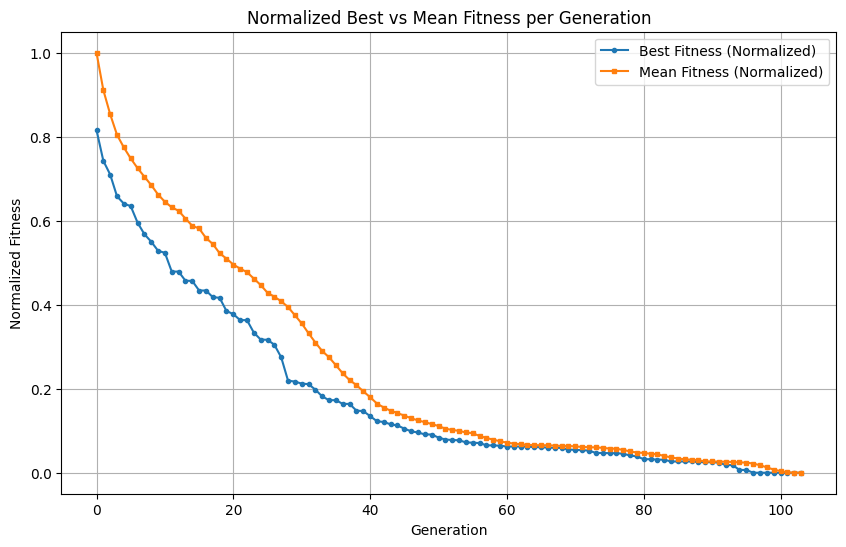

In [88]:
min_val = min(min(best_fitness), min(avg_fitness))
max_val = max(max(best_fitness), max(avg_fitness))

best_fitness_norm = [(x - min_val) / (max_val - min_val) for x in best_fitness]
avg_fitness_norm = [(x - min_val) / (max_val - min_val) for x in avg_fitness]

gen_num = list(range(len(best_fitness)))

plt.figure(figsize=(10, 6))
plt.plot(gen_num, best_fitness_norm, label='Best Fitness (Normalized)', marker='o', ms=3)
plt.plot(gen_num, avg_fitness_norm, label='Mean Fitness (Normalized)', marker='s', ms=3)

plt.xlabel('Generation')
plt.ylabel('Normalized Fitness')
plt.title('Normalized Best vs Mean Fitness per Generation')
plt.legend()
plt.grid(True)
plt.show()